### Imports

In [1]:
# Import libraries

# Some base libs
import random, os, sys, shutil, pathlib, platform, zipfile, json, glob
from PIL import Image
from pycocotools.coco import COCO

# Core ML libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text libs
import re
import nltk

# TF / Keras libs
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, resnet_v2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Additional visualization libs
from livelossplot.keras import PlotLossesCallback
from tensorflow.keras.utils import plot_model
import visualkeras

# Sklearn libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


### Datasets

In [2]:
# These are the datasets we are using

# https://www.kaggle.com/datasets/shadikfaysal/fruit-and-vegetables-ssm
# https://www.kaggle.com/datasets/ishandandekar/fruitimagedataset
# https://www.kaggle.com/datasets/kvnpatel/fruits-vegetable-detection-for-yolov4
# https://www.kaggle.com/datasets/moltean/fruits
# https://www.kaggle.com/datasets/bjoernjostein/food-classification
# https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
# https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
# https://www.kaggle.com/datasets/moohsassin/fruits-vegetables-wo-360
# https://www.kaggle.com/datasets/dansbecker/food-101
# https://www.kaggle.com/datasets/balalexv/fruits-vegetables-photos
# https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

### Checks

In [3]:
# Ensure GPU is enabled for training

devices = tf.config.list_physical_devices('GPU')
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Check versions

print(platform.python_version())
print(tf.__version__)

3.9.13
2.9.0


In [5]:
pd.set_option('display.max_rows', 500)

In [6]:
# Check what dir we are in
%pwd

'C:\\Users\\Nimai\\PycharmProjects\\TDI-Capstone'

### Data Preperation

In [7]:
# Extract a zip file

def extract_zip(path_to_zip, target_dir):
    if os.path.exists(target_dir):
        print('Target dir already exists, likely already extracted, skipping...')
        return
    
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

In [ ]:
# Start extracting all our datasets (first few require fixing up)

In [ ]:
extract_zip('data/food-classification.zip','data/extracted/food-classification')

In [ ]:
# This dataset has the training class names in a dataframe
# Remove test images which have no labels and create folders for the training images

In [ ]:
## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree('data/extracted/food-classification/test_images')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

In [ ]:
df_tmp = pd.read_csv('data/extracted/food-classification/train_img.csv')

In [ ]:
df_tmp

In [ ]:
names_dict = dict(zip(df_tmp['ImageId'], df_tmp['ClassName']))

for file in list(pathlib.Path('data/extracted/food-classification').glob(r'**/**/*.jpg')):
    path = os.path.split(file)[0]
    filename = os.path.split(file)[1]
    classname = names_dict[filename]
    
    if not os.path.exists(os.path.join(path,classname)):
        os.makedirs(os.path.join(path,classname))
    
    os.rename(os.path.join(path,filename),os.path.join(path,classname,filename))

In [ ]:
extract_zip('data/fruits-vegetable-detection-for-yolov4.zip','data/extracted/fruits-vegetable-detection-for-yolov4')

In [ ]:
# This dataset has the class name embedded in the filename, fix

In [ ]:
for file in list(pathlib.Path('data/extracted/fruits-vegetable-detection-for-yolov4').glob(r'**/**/*.jpg')):
    path = os.path.split(file)[0]
    filename = os.path.split(file)[1]
    match = re.search(r'[a-zA-Z]+', filename).group()
    
    if not os.path.exists(os.path.join(path,match)):
        os.makedirs(os.path.join(path,match))
    
    os.rename(os.path.join(path,filename),os.path.join(path,match,filename))

In [ ]:
# This includes lots of misc items outside of fruits/vegetables

In [ ]:
extract_zip('data/food-recognition-2022.zip','data/extracted/food-recognition-2022')

In [ ]:
train_coco = COCO(r'data\extracted\food-recognition-2022\raw_data\public_training_set_release_2.0\annotations.json')

In [ ]:
cat_info = pd.DataFrame(train_coco.loadCats(train_coco.getCatIds()))

In [ ]:
cat_info = cat_info.rename(columns={'id': 'cat_id'})

In [ ]:
cat_info.head()

In [ ]:
img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))

In [ ]:
img_info

In [ ]:
annot_info = pd.DataFrame(train_coco.loadAnns(train_coco.getAnnIds()))

In [ ]:
annot_info = annot_info.rename(columns={'id': 'annot_id'})

In [ ]:
annot_info

In [ ]:
fr_merged_df = img_info.merge(annot_info, how='inner', left_on='id', right_on='image_id')

In [ ]:
fr_merged_df = fr_merged_df.merge(cat_info, how='inner', left_on='category_id', right_on='cat_id')

In [ ]:
fr_merged_df = fr_merged_df[['annot_id','image_id','category_id','file_name','name','name_readable']]

In [ ]:
# One big issue with the dataset is this is meant for multiple foods in one image, so only keep the images which have one class
fr_merged_df = fr_merged_df.groupby('image_id').filter(lambda x: x['name'].count() == 1)

In [ ]:
fr_merged_df

In [ ]:
prepend_path = r'data\extracted\food-recognition-2022\raw_data\public_training_set_release_2.0\images'
target_path = r'data\extracted\food-recognition-2022\images'

for idx, row in fr_merged_df.iterrows():
    classname = row['name']
    filename = row['file_name']
    
    if not os.path.exists(os.path.join(target_path,classname)):
        os.makedirs(os.path.join(target_path,classname))
        
    os.rename(os.path.join(prepend_path,filename),os.path.join(target_path,classname,filename))
    
try:
    shutil.rmtree(r'data\extracted\food-recognition-2022\raw_data')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

In [ ]:
# Extract the rest, these datasets are clean enough to use as is

In [ ]:
extract_zip('data/fruitimagedataset.zip','data/extracted/fruitimagedataset')

In [ ]:
extract_zip('data/fruit-and-vegetable-image-recognition.zip','data/extracted/fruit-and-vegetable-image-recognition')

In [ ]:
extract_zip('data/fruit-and-vegetables-ssm.zip','data/extracted/fruit-and-vegetables-ssm')

In [ ]:
extract_zip('data/fruits-vegetables-photos.zip','data/extracted/fruits-vegetables-photos')

In [ ]:
extract_zip('data/fruits-vegetables-wo-360.zip','data/extracted/fruits-vegetables-wo-360')

In [ ]:
extract_zip('data/vegetable-image-dataset.zip','data/extracted/vegetable-image-dataset')

In [ ]:
#extract_zip('data/fruit-262.zip','data/extracted/fruit-262')

### Data Cleaning

In [8]:
image_dir = pathlib.Path('data/extracted')

In [9]:
paths = list(image_dir.glob(r'**/**/*.jpg'))

In [10]:
paths[:5]

[WindowsPath('data/extracted/food-classification/train_images/train_images/almonds/105105b190.jpg'),
 WindowsPath('data/extracted/food-classification/train_images/train_images/almonds/1206811c45.jpg'),
 WindowsPath('data/extracted/food-classification/train_images/train_images/almonds/1253a27744.jpg'),
 WindowsPath('data/extracted/food-classification/train_images/train_images/almonds/13dedda029.jpg'),
 WindowsPath('data/extracted/food-classification/train_images/train_images/almonds/150b05fd5f.jpg')]

In [11]:
len(paths)

211062

In [12]:
labels = list(map(lambda x: pathlib.PurePath(x).parent.name.lower(), paths))

In [13]:
labels[0]

'almonds'

In [14]:
labels[-1]

'tomato'

In [15]:
paths_series = pd.Series(paths, name='Filepath').astype(str)
labels_series = pd.Series(labels, name='Label')

In [16]:
# Join the series side by side
df = pd.concat([paths_series, labels_series], axis=1)

In [17]:
df['Label'].nunique()

642

In [18]:
def sanitize_df(df):
    
    # Step 1: Map extraneous / erroneous values with proper name
    
    df['Label'] = df['Label'].str.strip()

    mapping_dict = {
            'avocado ripe': 'avocado',
            'banana lady finger': 'banana',
            'bellpepper': 'bell pepper',
            'brinjal': 'eggplant',
            'capsicum': 'bell pepper',
            'pepper green': 'bell pepper',
            'carambola': 'star fruit',
            'carambula': 'star fruit',
            'chilli':'chili',
            'chilli pepper': 'chili',
            'cocos': 'coconut',
            'coffee-with-caffeine': 'coffee',
            'white-coffee-with-caffeine': 'coffee',
            'dragon': 'dragon fruit',
            'pitahaya red': 'dragon fruit',
            'pitaya': 'dragon fruit',
            'dark-chocolate': 'chocolate',
            'kaki': 'persimmon',
            'espresso-with-caffeine': 'espresso',
            'ginger root': 'ginger',
            'green lemon': 'lemon',
            'lemon meyer': 'lemon',
            'jalepeno': 'jalapeno',
            'maracuja': 'passion fruit',
            'nectarine flat': 'nectarine',
            'peach flat': 'peach',
            'mango red': 'mango',
            'leaf-spinach': 'spinach',
            'salad-leaf-salad-green': 'salad green', 
            'mixed-salad-chopped-without-sauce': 'salad green',
            'raddish': 'radish',
            'sweetcorn':'corn',
            'water-mineral': 'water',
            'pineapple mini': 'pineapple',
            'onion red peeled': 'onion',
            'white mushroom': 'mushroom',
            'watermelon-fresh': 'watermelon',
            'carrot-raw': 'carrot',
            'bell-pepper-red-raw': 'pepper-red',
            'tomato-raw': 'tomato',
            'strawberry-wedge': 'strawberry',
            'sweetpotato': 'sweet potato'
    }
    df['Label'] = df['Label'].replace(mapping_dict)
      
    # Step 2: Remove digits, spaces, etc. in names
    df['Label'] = df['Label'].apply(lambda x: re.sub(r"\s*\d+\s*","", x))
    df['Label'] = df['Label'].str.replace(' ', '-', regex=True)
    df['Label'] = df['Label'].str.replace('_', '-', regex=True)
    df['Label'] = df['Label'].str.replace('-n-s', '', regex=True)
    df['Label'] = df['Label'].str.replace('-ch$', '', regex=True)
    
    # Step 3: Lemmatize names to account for plurals (e.g. tomato vs. tomatoes)
    #nltk.download('wordnet')
    wordnet = nltk.WordNetLemmatizer()
    df['Label'] = df['Label'].apply(lambda x: wordnet.lemmatize(x))
    
    # Step 4: Remove other items (e.g. names whose length exceeds 25 chars)
    # df = df.groupby('Label').filter(lambda x: x['Label'].str.len().lt(25))
    df = df[df['Label'].str.len().lt(25)].copy(deep=True)
    
    # Step 5: Drop things we don't have enough samples for, care about, or are duplicates
    df = df.groupby('Label').filter(lambda x: x['Filepath'].count() > 25)
    df = df[~df.Label.isin(['boisson-au-glucose-g', 
                            'glucose-drink-g', 
                            'lasagne-meat-prepared', 
                            'apple-red', 
                            'water-with-lemon-juice',
                            'bread--grain',
                            'potato-red-washed'])].copy()
    return df

In [22]:
df = sanitize_df(df)

In [23]:
df.nunique()

Filepath    204416
Label          250
dtype: int64

In [24]:
sorted(df['Label'].unique())

['almond',
 'apple',
 'apple-braeburn',
 'apple-crimson-snow',
 'apple-golden',
 'apple-granny-smith',
 'apple-pie',
 'apple-pink-lady',
 'apple-red-delicious',
 'apple-red-yellow',
 'apricot',
 'avocado',
 'banana',
 'banana-red',
 'bean',
 'beer',
 'beetroot',
 'bell-pepper',
 'berry',
 'biscuit',
 'bitter-gourd',
 'black-olives',
 'blackberry',
 'blueberry',
 'bottle-gourd',
 'braided-white-loaf',
 'bread',
 'bread-black',
 'bread-french-white-flour',
 'bread-fruit',
 'bread-grain',
 'bread-half-white',
 'bread-nut',
 'bread-pita',
 'bread-sourdough',
 'bread-ticino',
 'bread-toast',
 'bread-white',
 'bread-whole-wheat',
 'bread-wholemeal',
 'bread-wholemeal-toast',
 'broccoli',
 'brogle',
 'brownie',
 'butter',
 'cabbage',
 'cactus-fruit',
 'cake-chocolate',
 'cantaloupe',
 'cappuccino',
 'carrot',
 'cashew-nut',
 'cauliflower',
 'cheese',
 'cherry',
 'cherry-rainier',
 'cherry-wax-black',
 'cherry-wax-red',
 'cherry-wax-yellow',
 'chestnut',
 'chicken',
 'chili',
 'chips-french-fr

### Data Exploration

In [25]:
# Show one random image per class

In [26]:
def plot_images():
    # Visualize the data, show one image per class from 250 classes
    rows = 25
    cols = 10
    #plt.figure(figsize=(25,25))
    # fig = plt.figure()
    fig, ax = plt.subplots(rows, cols, figsize=(25,25))
    fig.suptitle("One random image per class", y=1, fontsize=20)
    
    one_img_per_grp = df.sample(frac=1.0).groupby('Label').head(1).sort_values(by='Label')
    label_file_dict = dict(zip(one_img_per_grp['Label'], one_img_per_grp['Filepath']))
    label_keys = list(label_file_dict)
    key = 0

    for i in range(rows):
        for j in range(cols):
            food_path = label_file_dict[label_keys[key]]
            food_label = label_keys[key]
            
            img = plt.imread(food_path)
            ax[i,j].imshow(img)
            ax[i,j].axis('off')
            ax[i,j].set_title(str(key) + ": " + food_label, pad=10)
            key += 1
            
    plt.tight_layout()
    plt.show()

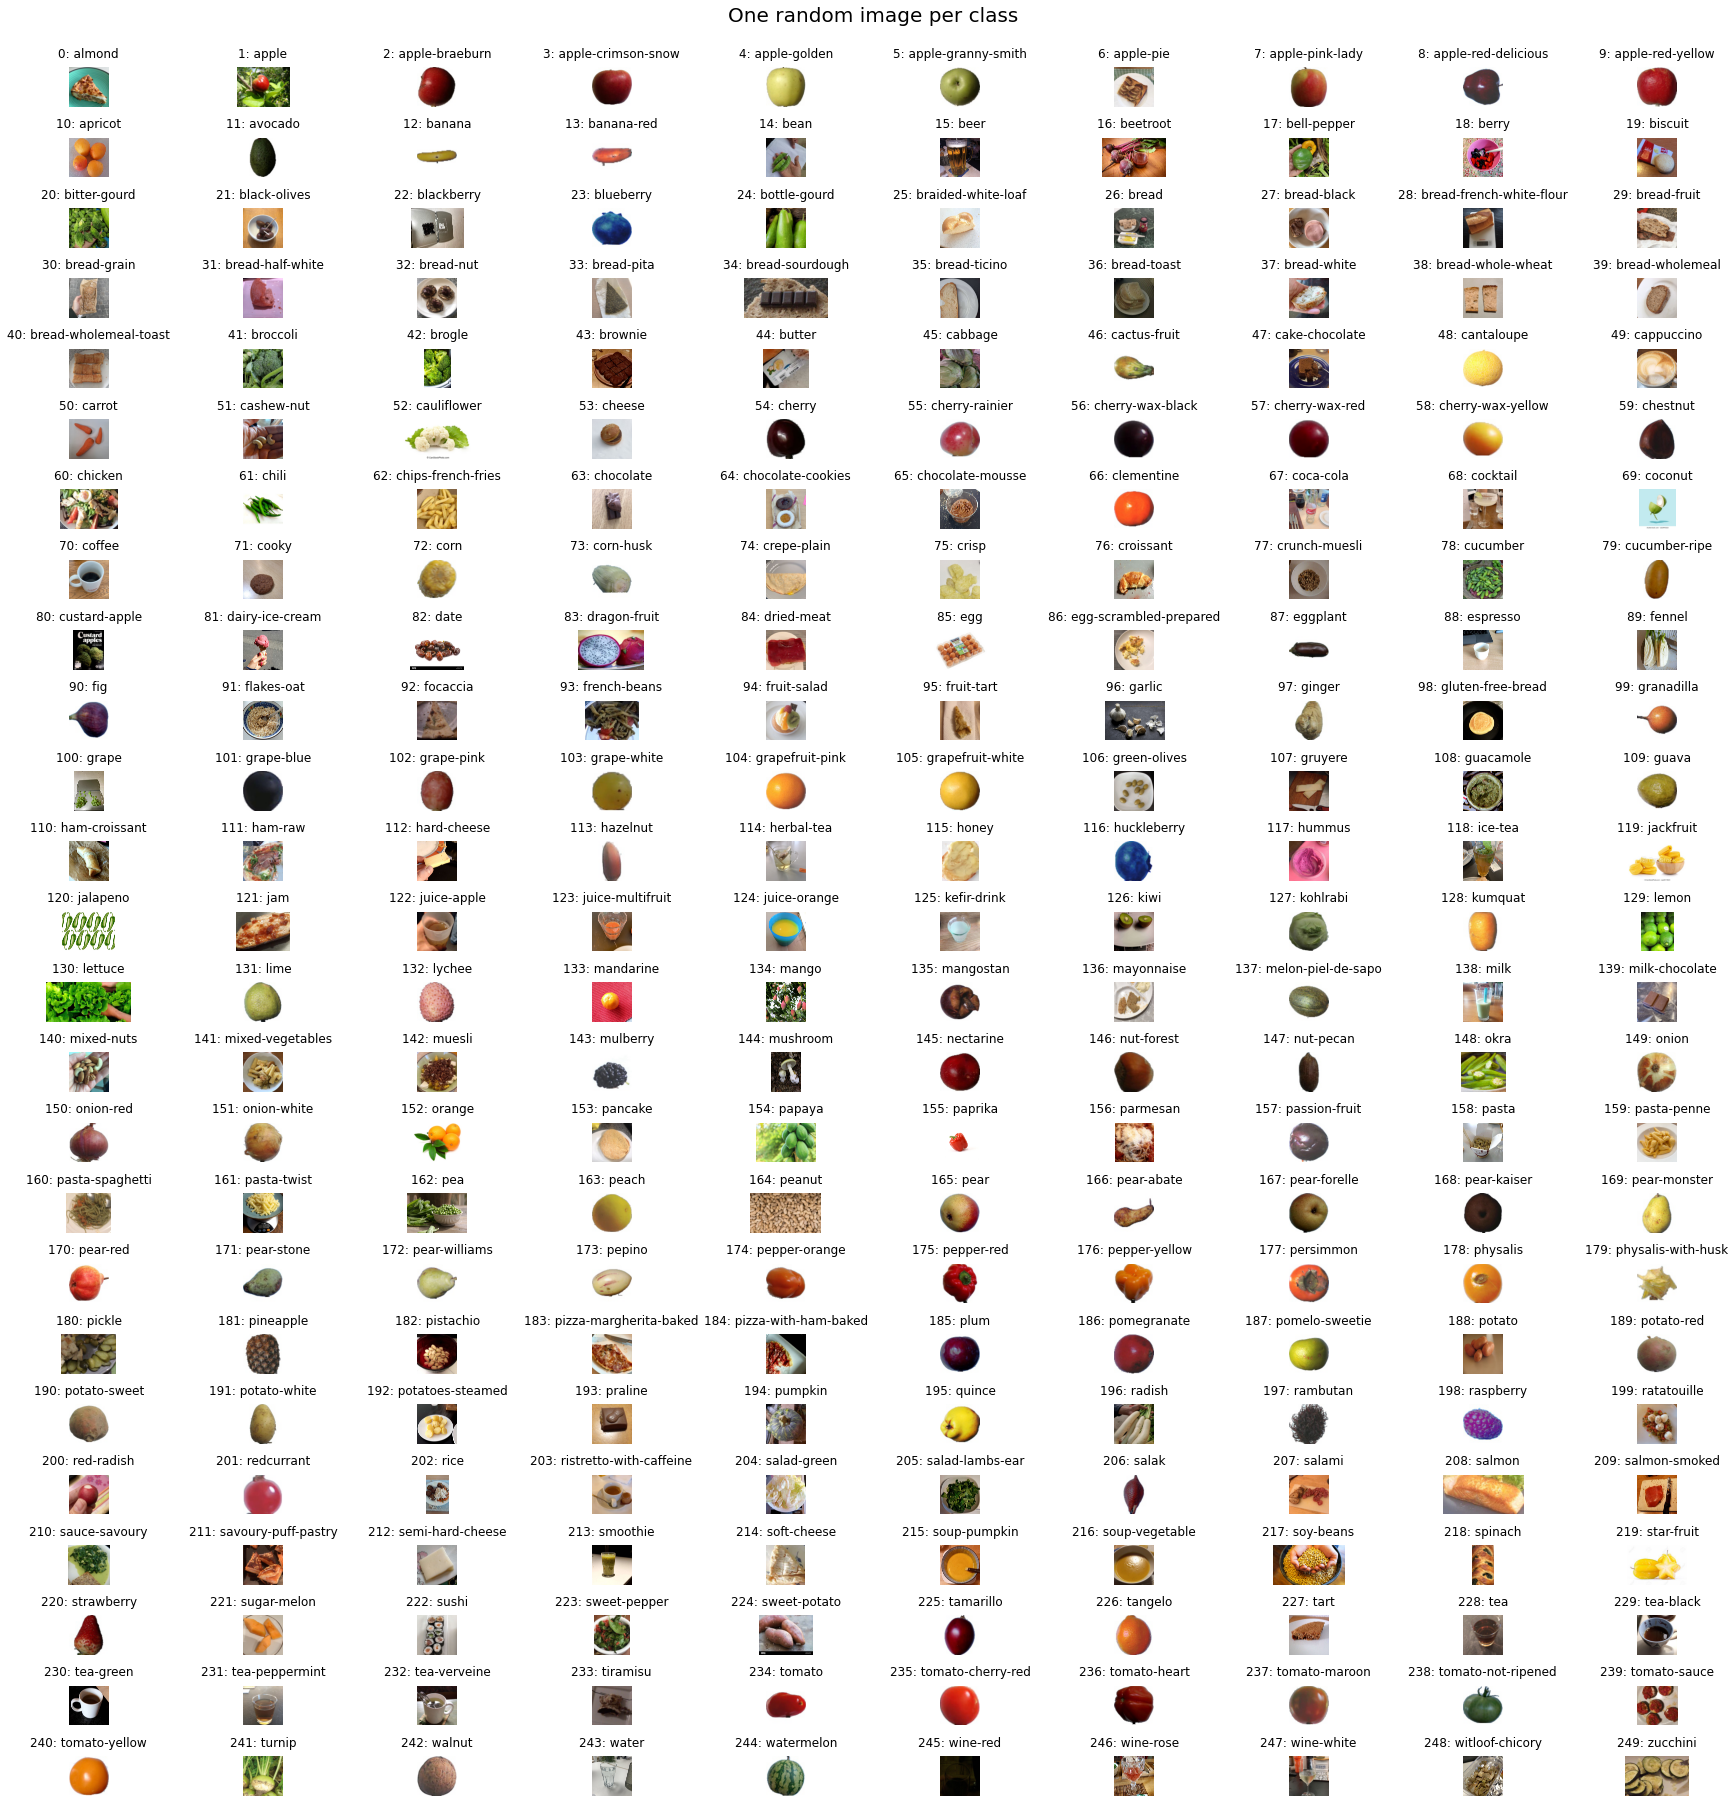

In [27]:
plot_images()

In [28]:
def plot_distribution(df):
    counts = df.groupby('Label')['Filepath'].count().sort_values(ascending=False)
    print(counts)
    
    plt.figure(figsize=(40,20))
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=90)
    plt.yticks()
    plt.grid()
    plt.show()

Label
tomato                      13110
pear                         7870
bell-pepper                  5499
banana                       5148
plum                         4702
peach                        4656
cauliflower                  3986
orange                       3683
water                        3569
strawberry                   3548
potato                       3292
onion                        3133
lemon                        3084
apple                        2925
eggplant                     2757
mango                        2681
papaya                       2655
carrot                       2645
grape-white                  2597
cucumber                     2291
grape                        2257
broccoli                     2126
corn                         2087
pineapple                    2049
watermelon                   2028
blueberry                    2027
coffee                       2010
apple-golden                 1938
dragon-fruit                 1912
star-fru

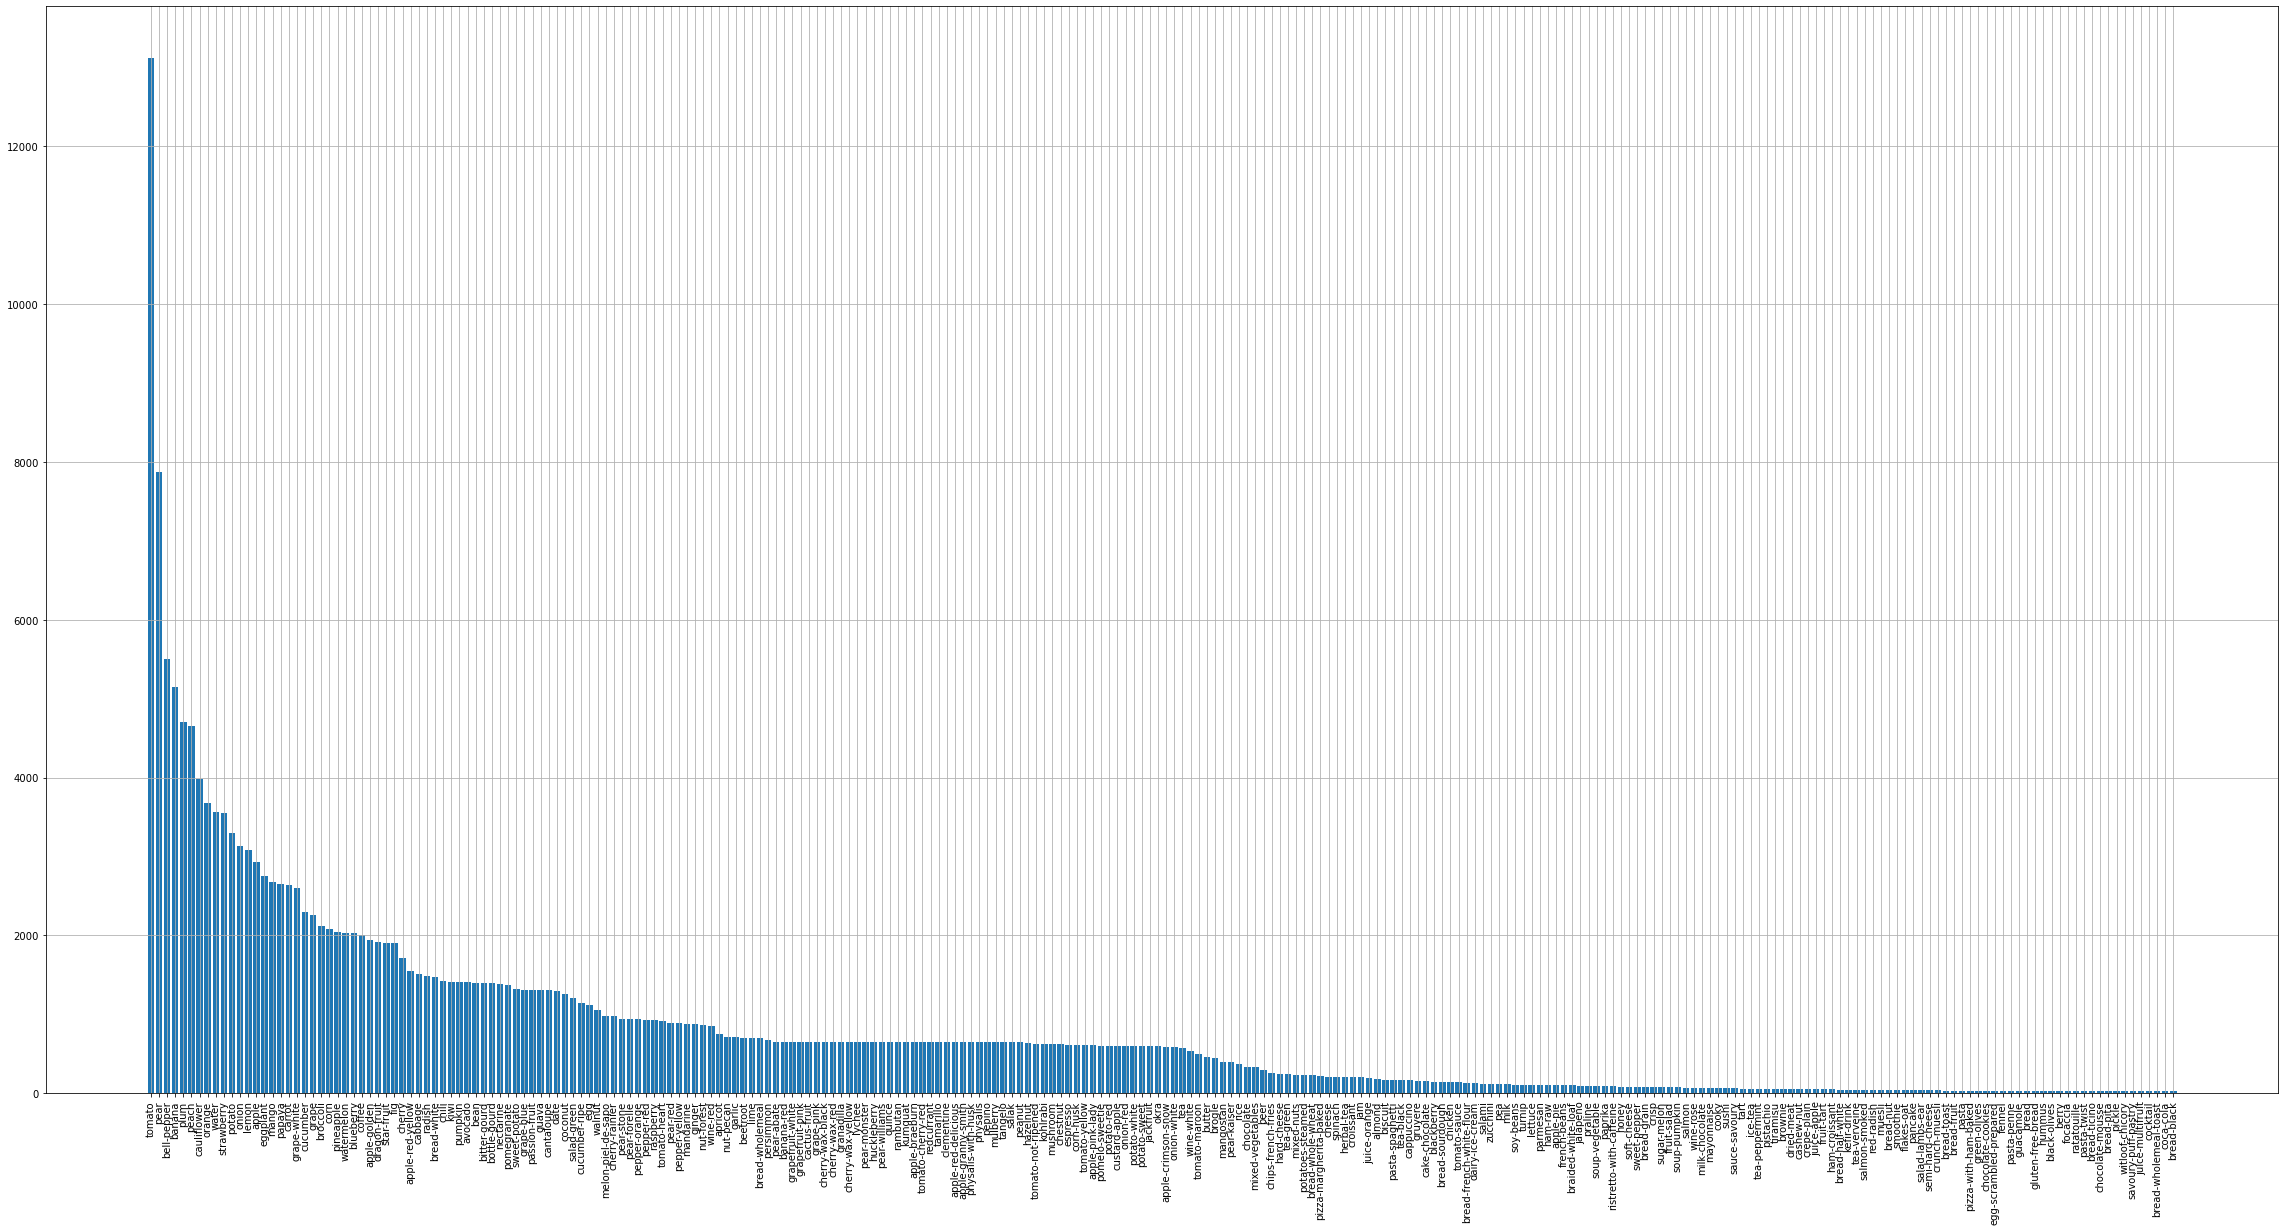

In [29]:
plot_distribution(df)

### Over / under sampling

In [30]:
def over_under_sample(df, num_samples):

    class_samples = []
    for label, df_subset in df.groupby('Label'):
        if df_subset.shape[0] < num_samples:
            # Over sample (with replacement)
            class_samples.append(df_subset.sample(num_samples, replace=True))
        else:
            # Under sample, take a subset, this will ensure proper weights when training
            class_samples.append(df_subset.sample(num_samples, replace=False))
        
    return class_samples

In [31]:
samples = over_under_sample(df, 500)
final_df = pd.concat(samples, axis=0).sample(frac=1.0).reset_index(drop=True)

In [32]:
final_df

Filepath            Label
0       data\extracted\fruit-and-vegetables-ssm\train\...       star-fruit
1       data\extracted\food-recognition-2022\images\pi...        pistachio
2       data\extracted\fruitimagedataset\train\train\C...    cucumber-ripe
3       data\extracted\fruitimagedataset\train\train\C...           cherry
4       data\extracted\fruitimagedataset\train\train\A...  apple-pink-lady
...                                                   ...              ...
124995  data\extracted\food-recognition-2022\images\he...       herbal-tea
124996  data\extracted\vegetable-image-dataset\Vegetab...             bean
124997  data\extracted\food-recognition-2022\images\ca...       cashew-nut
124998  data\extracted\food-recognition-2022\images\te...        tea-green
124999  data\extracted\fruits-vegetables-wo-360\dataSe...           ginger

[125000 rows x 2 columns]

Label
almond                      500
pear-stone                  500
pasta                       500
pasta-penne                 500
pasta-spaghetti             500
pasta-twist                 500
pea                         500
peach                       500
peanut                      500
pear                        500
pear-abate                  500
pear-forelle                500
pear-kaiser                 500
pear-monster                500
pear-red                    500
pear-williams               500
pomelo-sweetie              500
pepino                      500
pepper-orange               500
pepper-red                  500
pepper-yellow               500
persimmon                   500
physalis                    500
physalis-with-husk          500
pickle                      500
pineapple                   500
pistachio                   500
pizza-margherita-baked      500
pizza-with-ham-baked        500
plum                        500
passion-fruit               500
pa

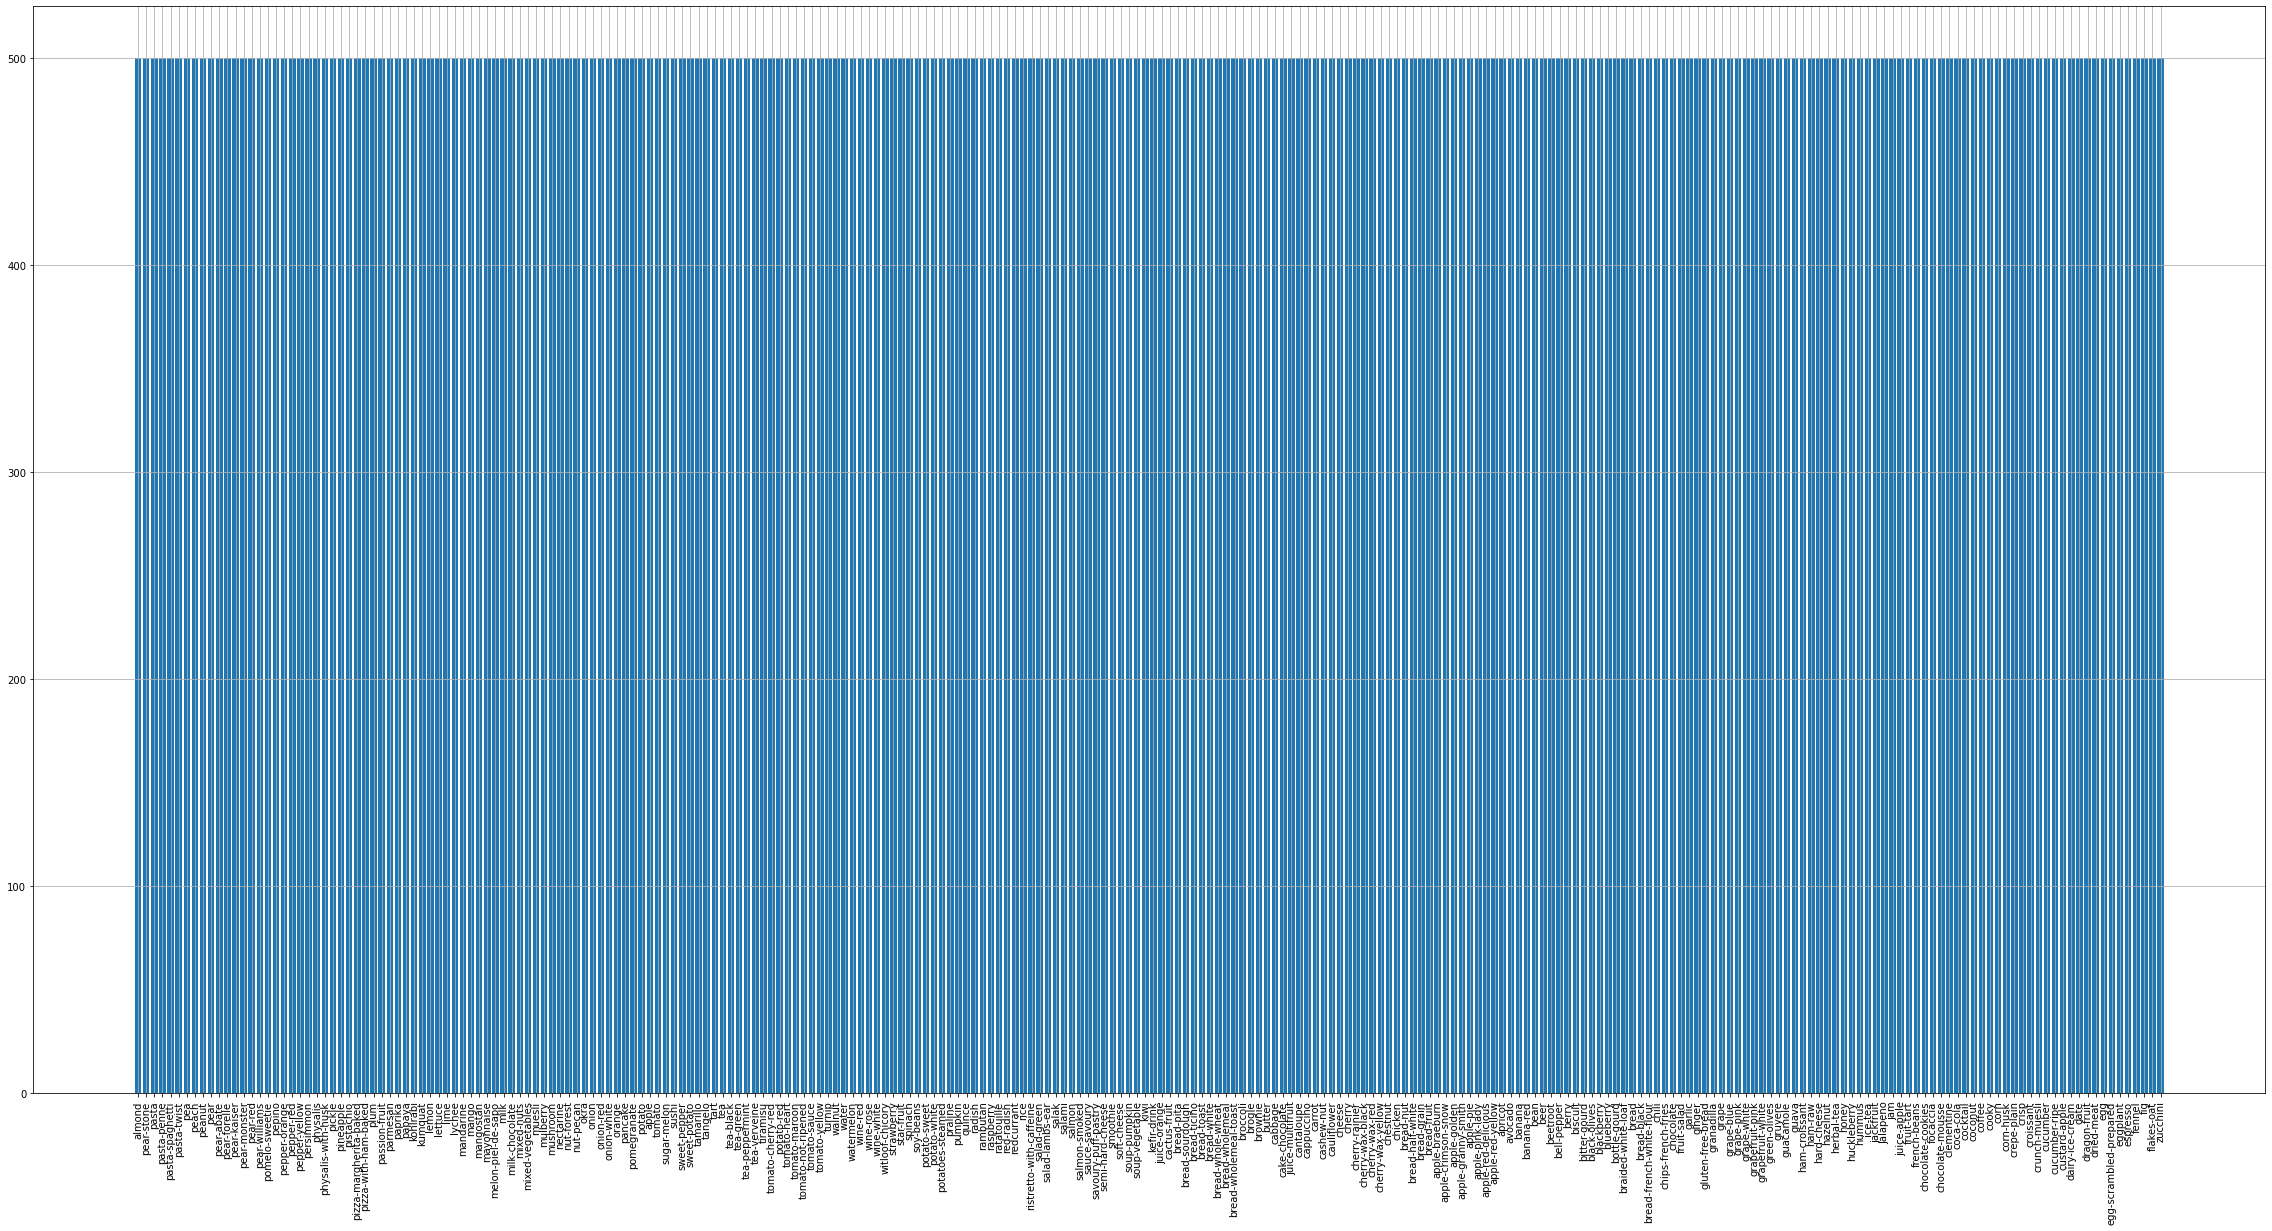

In [33]:
plot_distribution(final_df)

### Train / test split, image augmentation

In [34]:
# Use sklearn's train_test_split(), use 70% for training, 20% for validation, and 10% for test/holdout set
train_df, test_df = train_test_split(final_df, train_size=0.7, shuffle=True)

In [35]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

In [36]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    subset='training'
)

Found 70000 validated image filenames belonging to 250 classes.


In [37]:
val_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    subset='validation'
)

Found 17500 validated image filenames belonging to 250 classes.


In [38]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

Found 37500 validated image filenames belonging to 250 classes.


In [39]:
num_classes = len(np.unique(train_generator.classes))

In [40]:
num_classes

250

In [41]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  classes=np.unique(train_gen.classes),
#                                                  y=train_gen.classes)
# class_weight_dict = dict(enumerate(class_weights))

In [42]:
# TODO: plot some augmented images

### Model Building

In [43]:
# Let's create a method for a ResNet50v2 model we can fine tune

def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with ResnetV2 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'adam'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = ResNet50V2(include_top=False,
                           weights='imagenet',
                           pooling='avg',
                           classes=n_classes,
                           input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    # top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    # top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [44]:
# Define some critical parameters for our model
input_shape = (224, 224, 3)
optimizer = Adam(learning_rate=0.0001)
n_classes=num_classes
batch_size = train_generator.batch_size

n_steps = train_generator.samples // batch_size
n_val_steps = val_generator.samples // batch_size
n_epochs = 50

In [45]:
# Create the model with fine-tuning (unfreezing last 2 layers)

MODEL_EXISTS=False
# If model already exists on disk, use it
model_h5 = 'resnetv2_250_cls_92_acc.hdf5'
if os.path.isfile(model_h5):
    print("Model exists on disk, loading saved model...")
    resnet_model = tf.keras.models.load_model(model_h5)
    global MODEL_EXISTS
    MODEL_EXISTS = True
else:
    print("Model does not exist, creating new model...")
    resnet_model = create_model(input_shape, n_classes, optimizer, fine_tune=2)

Model does not exist, creating new model...


In [46]:
# Key Features of ResNet:
# ResNet uses Batch Normalization at its core. 
# The Batch Normalization adjusts the input layer to increase the performance of the network.
# ResNet makes use of the Identity Connection, which helps to protect the network from vanishing gradient problem.

In [47]:
print(resnet_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

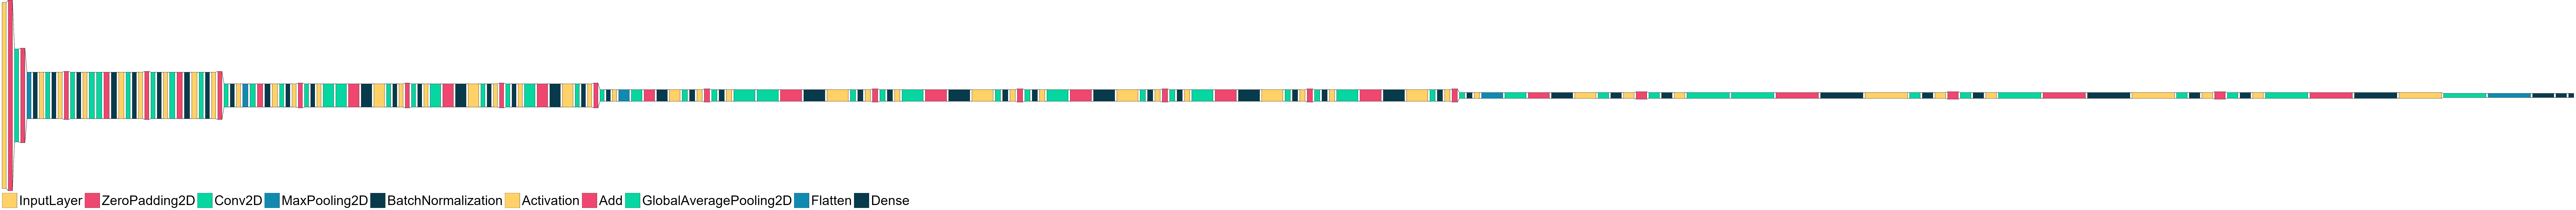

In [48]:
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 64) 
visualkeras.layered_view(resnet_model, legend=True, draw_volume=False, spacing=10, font=font)

### Model Training

In [49]:
# PlotLoss callback - plot accuracy and loss every epoch
plot_loss_cb = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=f'resnetv2_{num_classes}_classes.hdf5',
                                      save_best_only=True,
                                      verbose=1)

# EarlyStopping callback - stop training if val_loss does not improve for 'patience' epochs
early_stop_cb = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True,
                              mode='min')

# Reduce learing rate callback - adjust learning rate by 'factor' if val_loss does not improve for 'patience' epochs
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, 
                                 patience=3, 
                                 verbose=1)

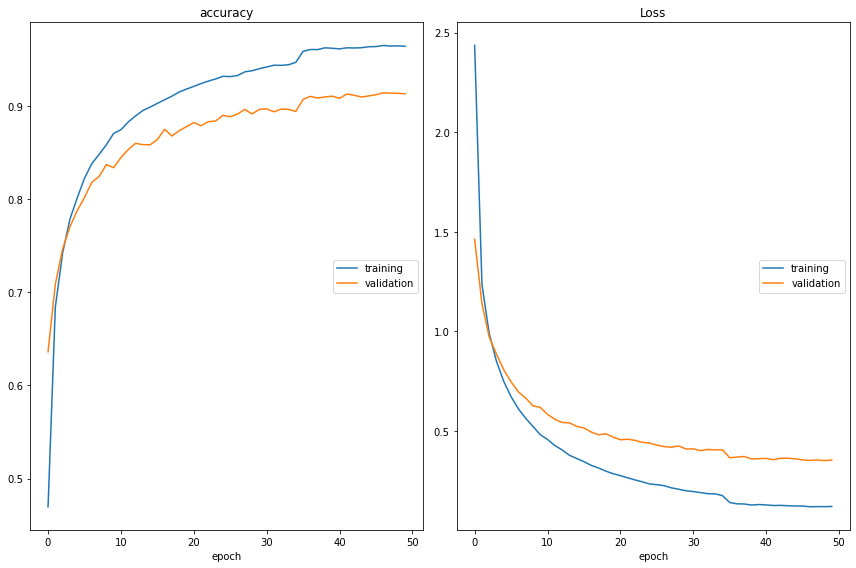

accuracy
	training         	 (min:    0.470, max:    0.965, cur:    0.964)
	validation       	 (min:    0.636, max:    0.914, cur:    0.913)
Loss
	training         	 (min:    0.120, max:    2.435, cur:    0.121)
	validation       	 (min:    0.351, max:    1.462, cur:    0.354)

Epoch 50: val_loss did not improve from 0.35110
546/546 [==============================] - 815s 1s/step - loss: 0.1210 - accuracy: 0.9640 - val_loss: 0.3540 - val_accuracy: 0.9130 - lr: 1.0000e-06


In [50]:
if not MODEL_EXISTS:
    # Fit/train the model only if it doesn't already exist
    resnet_history = resnet_model.fit(train_generator,
                                      batch_size=batch_size,
                                      epochs=n_epochs,
                                      validation_data=val_generator,
                                      steps_per_epoch=n_steps,
                                      validation_steps=n_val_steps,
                                      # class_weight=class_weight_dict,
                                      callbacks=[plot_loss_cb, model_checkpoint_cb, early_stop_cb, reduce_lr_cb],
                                      verbose=1)

In [51]:
results = resnet_model.evaluate(test_generator)

 52/293 [====>.........................] - ETA: 2:21 - loss: 0.3066 - accuracy: 0.9253

C:\Users\Nimai\anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


293/293 [==============================] - 171s 583ms/step - loss: 0.3137 - accuracy: 0.9232


In [52]:
print(f"Test Loss: {results[0]} | Test Accuracy: {results[1]}")

Test Loss: 0.3136749565601349 | Test Accuracy: 0.9232000112533569


In [53]:
y_pred = resnet_model.predict(test_generator)

293/293 [==============================] - 159s 541ms/step


In [54]:
y_pred_max = np.argmax(y_pred, axis=1)
cm_plot  = confusion_matrix(test_generator.labels, y_pred_max)
clr_plot = classification_report(test_generator.labels, y_pred_max, target_names=test_generator.class_indices)

In [55]:
with open('resnetv2_250_classes.json', 'w') as outfile:
    json.dump(train_generator.class_indices, outfile)

In [ ]:
# with open('class_names.json', 'r') as fp:
#     data = json.load(fp)

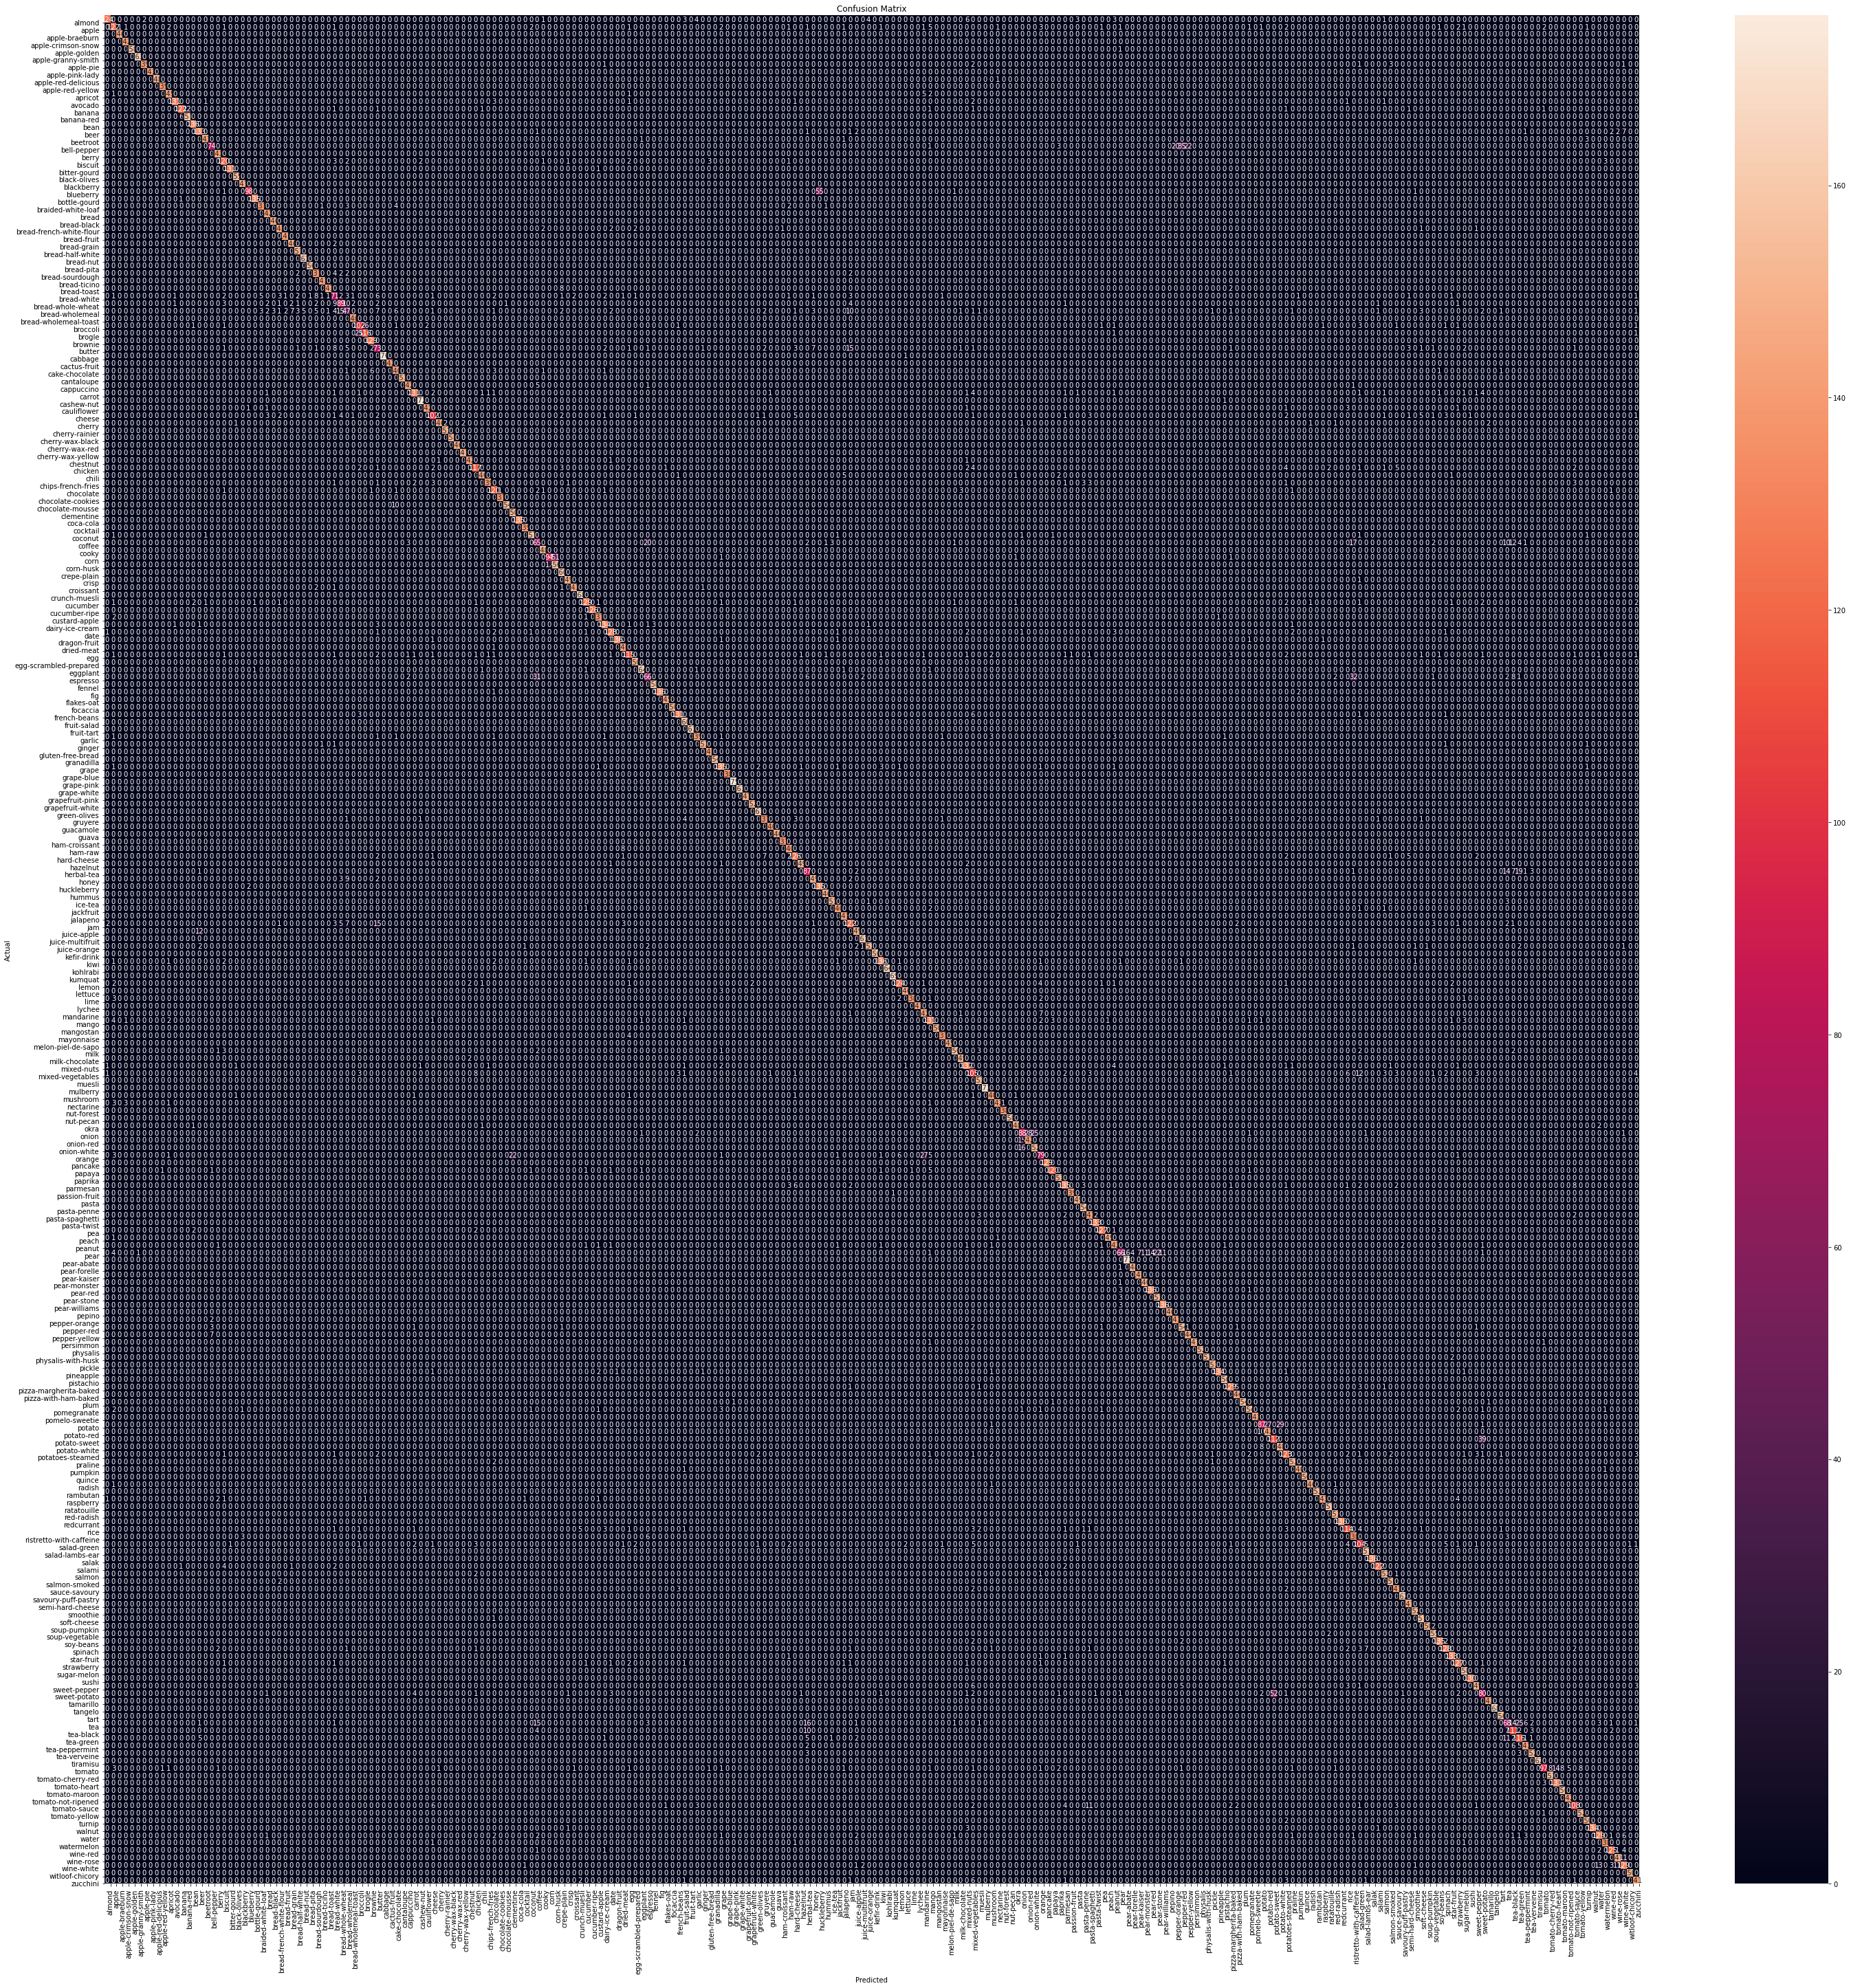

In [56]:
plt.figure(figsize=(50, 50))
sns.heatmap(cm_plot, annot=True, fmt='g')
plt.xticks(ticks=np.arange(num_classes) + 1, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(num_classes) + 1, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [57]:
print("Classification Report:\n", clr_plot)

Classification Report:
                           precision    recall  f1-score   support

                  almond       0.95      0.82      0.88       151
                   apple       0.77      0.76      0.77       160
          apple-braeburn       0.99      1.00      1.00       146
      apple-crimson-snow       0.97      1.00      0.98       142
            apple-golden       1.00      0.99      1.00       159
      apple-granny-smith       0.99      1.00      1.00       163
               apple-pie       0.99      0.95      0.97       147
         apple-pink-lady       1.00      1.00      1.00       143
     apple-red-delicious       1.00      0.99      1.00       149
        apple-red-yellow       0.99      1.00      0.99       139
                 apricot       0.95      0.94      0.94       154
                 avocado       0.98      0.93      0.95       141
                  banana       0.94      0.86      0.90       142
              banana-red       0.93      0.96      

In [58]:
# Save the class indices in the correct order

true_classes = test_generator.labels
class_indices = dict((v,k) for k,v in train_generator.class_indices.items())

### Check predictions

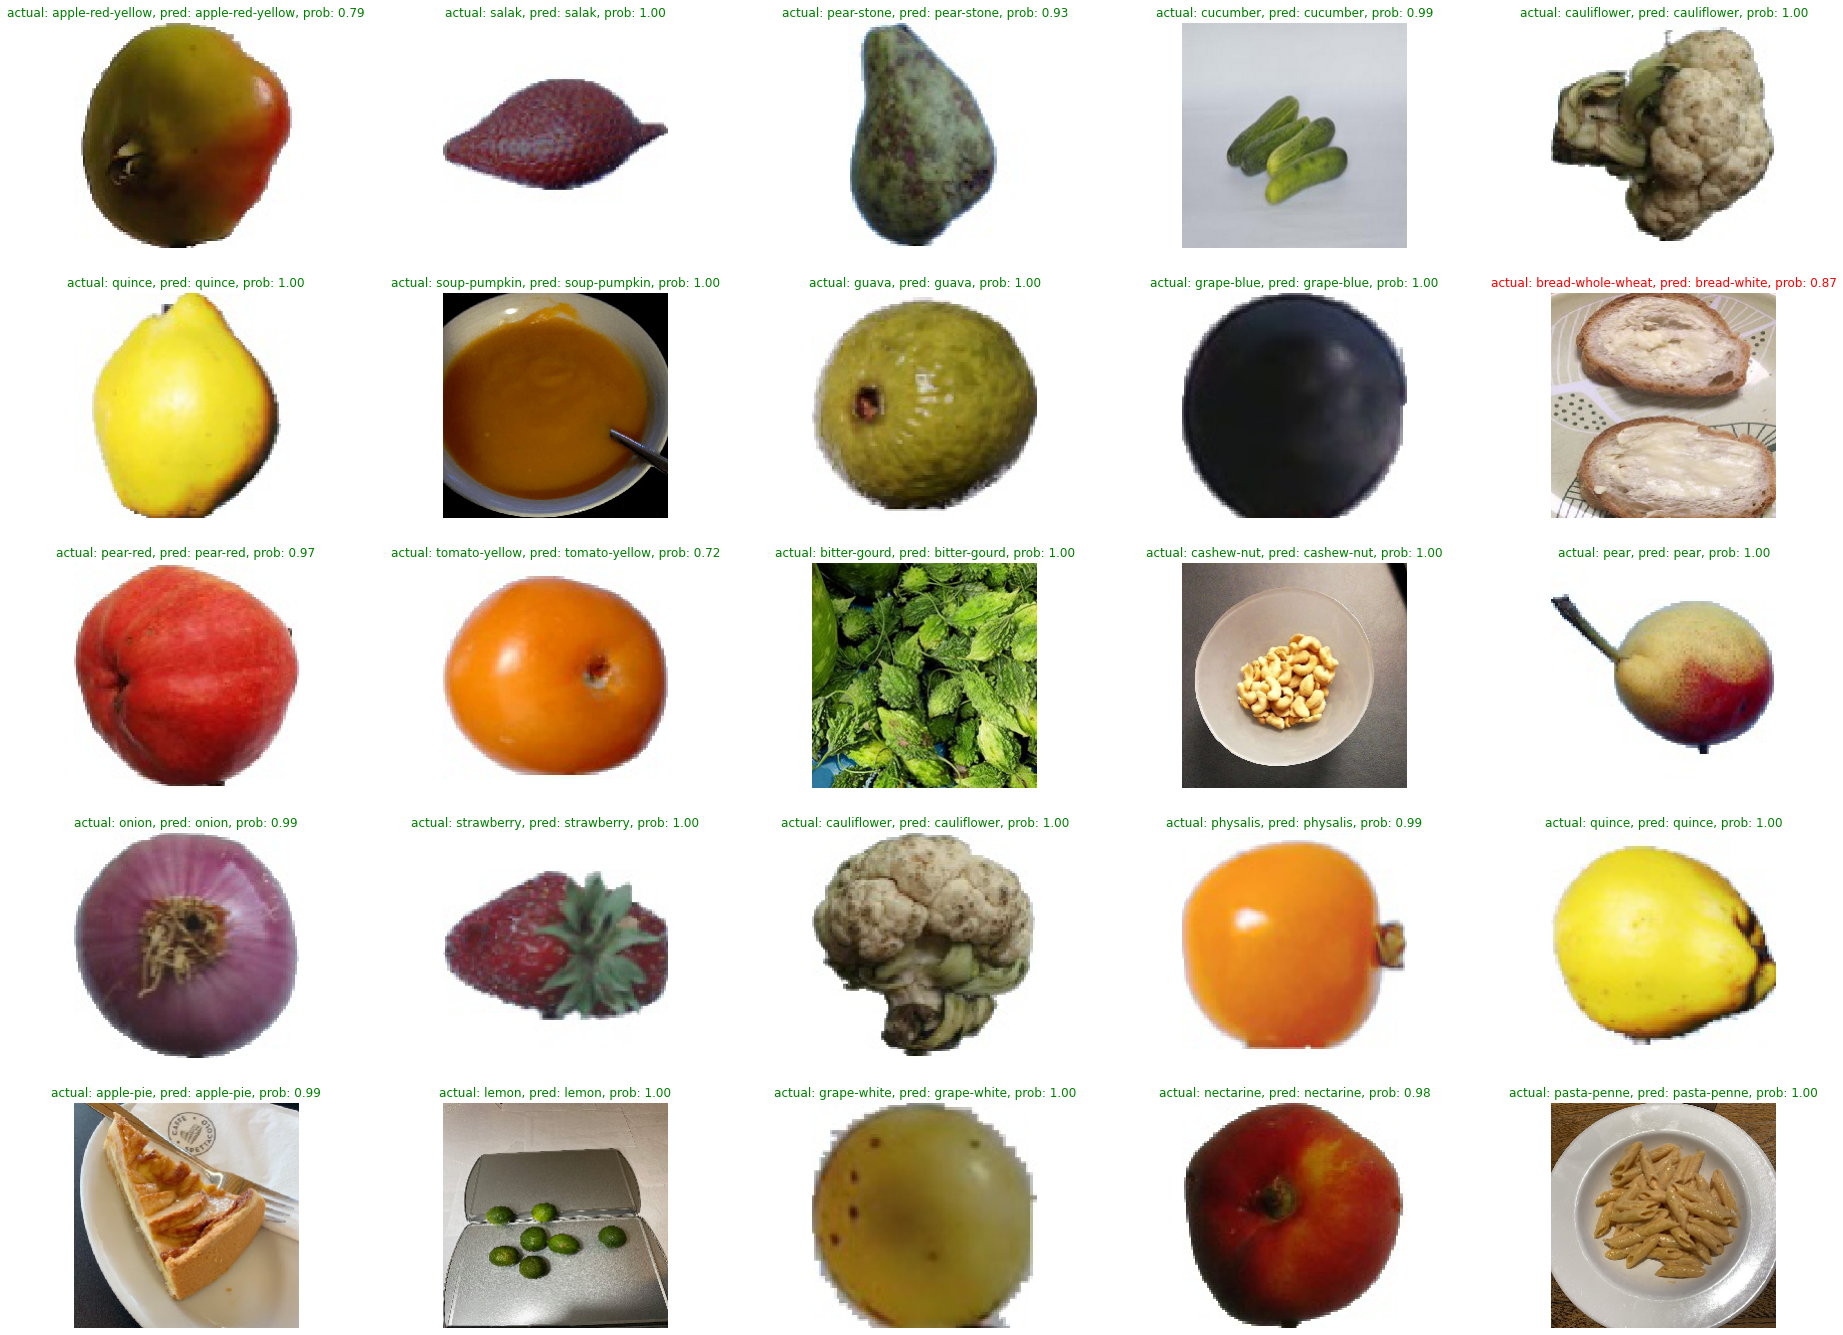

In [61]:
# Make preds on a series of random images
plt.figure(figsize=(32, 24))
for i in range(25):
    # Choose a random image from a random class 
    filepath = random.choice(pd.unique(test_df["Filepath"]))
    class_name = test_df[test_df.Filepath == filepath]['Label'].values[0]

    # Load the image and make predictions
    image_obj = image.load_img(filepath, target_size = (224, 224))
    img = image.img_to_array(image_obj)
    img = np.expand_dims(img, axis=0)
    img = resnet_v2.preprocess_input(img)
    
    pred_prob = resnet_model.predict(img,verbose=0) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_indices[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(5, 5, i+1)
    plt.imshow(image_obj)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

In [63]:
# Test some images downloaded off the internet

for filepath in pathlib.Path(r'data/test').glob('*'):
    print('File:', filepath)
    test_image = image.load_img(filepath, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = resnet_v2.preprocess_input(test_image)
    
    # Predicting the final top 3 classes
    test_result = resnet_model.predict(test_image, verbose=0)
    
    prediction_probabilities = tf.nn.top_k(test_result, k=3)
    top_k_prob = list(prediction_probabilities.values.numpy()[0])
    top_k_class_idx = list(prediction_probabilities.indices.numpy()[0])
    
    top_classes = [ (class_indices[top_k_class_idx[i]], top_k_prob[i]) for i in range(len(top_k_prob)) ]
    
    print('The predicted top 3 classes are:', top_classes)

File: data\test\apple.jpg
The predicted top 3 classes are: [('apple', 0.9067116), ('apple-crimson-snow', 0.08449091), ('apple-pink-lady', 0.0067574717)]
File: data\test\avocado.jpg
The predicted top 3 classes are: [('avocado', 0.9724855), ('beetroot', 0.011039162), ('melon-piel-de-sapo', 0.007742726)]
File: data\test\bell-pepper-green.jpg
The predicted top 3 classes are: [('paprika', 0.9642344), ('bell-pepper', 0.018888833), ('chili', 0.010802198)]
File: data\test\coconut.jpg
The predicted top 3 classes are: [('mushroom', 0.682187), ('coconut', 0.2559822), ('egg', 0.027055869)]
File: data\test\countertop-potatoes.jpg
The predicted top 3 classes are: [('mango', 0.2770951), ('bread-white', 0.25910857), ('potato', 0.18938485)]
File: data\test\cucumber.jpg
The predicted top 3 classes are: [('cucumber', 0.9999858), ('apple', 1.1749569e-05), ('bread-french-white-flour', 1.1976939e-06)]
File: data\test\eggplant.jpg
The predicted top 3 classes are: [('eggplant', 0.7130346), ('jalapeno', 0.2384